In [2]:
import torch
from torch import nn, optim, Tensor
from torch.nn import functional as F
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

# Deep Q-Network for CartPole

## Q-Estimator & Policy

DQN is a value-based method learning $Q^*$ with a deep network $Q_\theta$.

We'll implement it as a MLP. Consider `CartPole-v1`'s observation & action space:
$$\mathcal{S}\subset \mathbb{R}^4,~ \mathcal{A} = \{ 0, 1 \}$$

Therefore, as it has a discrete action space, we'll let the estimator take $s$ and produce both $Q_\theta(s, a)~(a=0,1)$ as output.

In [3]:
class Qnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fcs = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),

            nn.Linear(32, 16),
            nn.ReLU(),

            nn.Linear(16, 2),
        )
    
    def forward(self, state):
        q = self.fcs(state)
        return q

Value-based methods use dererministic policy $\pi(a|s) = 1 - \varepsilon \iff a = \argmax\limits_{a} ~Q_\theta(s,a)$. However, we adopt the $\varepsilon$-greedy method, letting the policy explore at a possibility of $\varepsilon$:

In [4]:
eps = 0.005

def policy(q: Tensor) -> int:
    explore = torch.bernoulli(torch.tensor(eps)).item()
    action = torch.argmax(q).item()
    if explore == 1:
        return abs(1 - action) # type: ignore
    else:
        return action # type: ignore

## Define Training Procedure

Q-Learning adopts TD-error. In fact(this is not a proof), with the *Bellman's Optimal Equation* we have:

$$
Q^{*}(s,a)=r+\gamma \mathbb{E}_{s' \sim P(\cdot|s,a)} \left[ \max_{a'} Q^{*}(s', a') \vert s,a \right]
$$

by approximately using $Q_\theta$ for predicting the next timestep, we can construct TD-loss as

$$
\begin{align*}
\mathcal{L}(\theta) &=\frac{1}{2} \lvert\rvert Q^{*}(s,a) - Q_{\theta}(s,a) \rvert\rvert _{2}^{2} \\
&=\frac{1}{2} \lvert\rvert r + \gamma \,\mathop{\text{max}}\limits_{a'}\,[\text{nograd}(Q_{\theta}(s',a'))]- Q_{\theta}(s,a) \rvert\rvert _{2}^{2}
\end{align*}
$$

During training, we run policy on the environment and collect losses between each two time steps:

In [5]:
gamma = 0.99

def trajectory(net, env):
    obs, _ = env.reset()
    tot_reward = 0
    losses: list[Tensor] = []

    scale = torch.tensor([4.8, 1, 0.418, 1])
    q_last = None
    reward_last = None
    loss = torch.tensor(0.)
    t = 0
    while True:
        q = net(torch.from_numpy(obs) / scale)
        if q_last != None and reward_last != None:
            # with torch.no_grad():
            qh = reward_last + gamma * torch.max(q)
            loss = F.mse_loss(q_last, qh)
            losses.append(loss)
        action = policy(q)
        obs, reward, term, trunc, _ = env.step(action)

        tot_reward += float(reward)
        reward_last = float(reward)
        q_last = q[action]

        if term or trunc: break
        t = t + 1

    return losses, tot_reward

## Run Training

As a functional-style lover, we'd love to collect batch results as a list, and use `batch` to process that list, returning average loss & per-trajectory total reward.

In [6]:
def average(results: list[tuple[list[Tensor], float]]) -> tuple[Tensor, float]:
    loss = reward = 0.
    for l, r in results:
        loss += sum(l)
        reward += r
    n = len(results)
    loss /= n; reward /= n
    return loss, reward # type: ignore

''' A result visulizer, by the way '''
def visualize(metrics):
    plt.subplot(211)
    plt.plot([m['reward'] for m in metrics])
    plt.ylabel('reward')
    plt.subplot(212)
    plt.plot([m['qloss'] for m in metrics], 'r')
    plt.xlabel('t')
    plt.ylabel('qloss')

The `plain_train` just collets the average batch-loss and perform backprop for each batch for now.

In [7]:
def plain_train(net, env, opt, *, epochs=200, batches=10):
    metrics = []
    for e in range(epochs):
        loss, reward = average([trajectory(net, env) for _ in range(batches)])
        opt.zero_grad()
        loss.backward()
        opt.step()
        metrics.append({
            'reward': reward,
            'qloss': loss.item(),
        })
    return metrics

''' Prepare for training '''
lr = 0.002
net = Qnet()
opt = optim.Adam(net.parameters(), lr=lr)
env = gym.make('CartPole-v1', render_mode=None)
ms = [] # a list for results

Now you can run the code block below several times to train the Q-model till convergence:

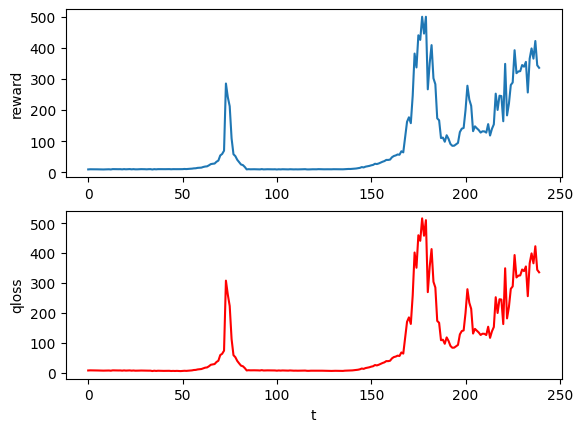

In [9]:
ms += plain_train(net, env, opt, epochs=120)
visualize(ms)

## Stablizing the Training: Experience Replay & Seperated Target Net

As you see the `plain_train` is really unstable. We'll first introduce "experience replay", which collects and shuffle losses to make each batch individual:

In [165]:
type Experience = tuple[Tensor, int, float, Tensor] # s, a, r, s'

def trajectory_exp(net, env):
    obs, _ = env.reset()
    exps: list[Experience] = []

    scale = torch.tensor([4.8, 1, 0.418, 1])
    while True:
        q = net(torch.from_numpy(obs) / scale)
        action = policy(q)
        obsn, reward, term, trunc, _ = env.step(action)
        exps.append((torch.as_tensor(obs), action, reward, torch.as_tensor(obsn)))
        obs = obsn

        if term or trunc: break

    return exps

In [ ]:
from random import sample
from functools import reduce

def replay_train(net, env, opt, *, epochs=200, batches=10, tsteps=100):
    def concat(l1: list, l2: list) -> list: return l1 + l2

    experience: list[Experience] = reduce(concat, [trajectory_exp(net, env) for _ in range(epochs * batches)])
    metrics = []
    for _ in range(epochs):
        exps = sample(experience, k=tsteps)
        opt.zero_grad()
        loss = torch.tensor(0.)
        for s, a, r, sn in exps:
            # with torch.no_grad():
            tar = r + gamma * net(sn).max()
            est = net(s)[a]
            loss += F.mse_loss(est, tar)
        loss.backward()
        opt.step()

        tst_loss, tst_reward = average([trajectory(net, env) for _ in range(3)])
        metrics.append({
            'reward': tst_reward,
            'qloss' : tst_loss.item()
        })

    return metrics


''' Prepare for training '''
lr = 0.002
net = Qnet()
opt = optim.Adam(net.parameters(), lr=lr)
ms = [] # a list for results

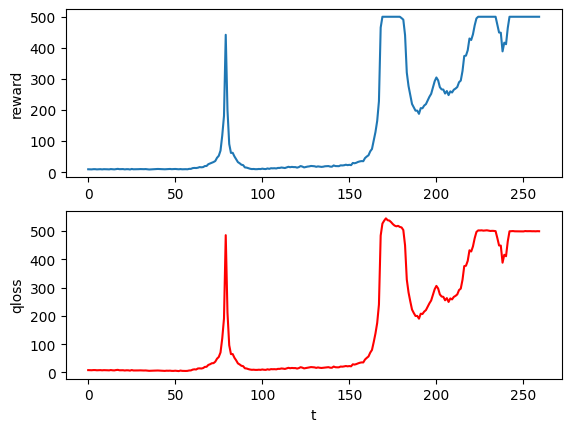

In [183]:
ms += replay_train(net, env, opt, epochs=20)
visualize(ms)